In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
import pandas as pd
import glob
import os 

2024-07-18 09:51:03.244186: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Test MSE loss similarity 
i = 10
rand_polymer_1 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
rand_polymer_2 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
rand_polymer_1 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_1])
rand_polymer_2 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_2])
assigned_polymer_1, assigned_polymer_2 = assign_clusters(rand_polymer_1, rand_polymer_2)
mse_loss_1 = np.mean([np.linalg.norm(x-y) for x, y in zip(assigned_polymer_1, assigned_polymer_2)])
mse_loss_2 = MSE_means(assigned_polymer_1, assigned_polymer_2)

In [18]:
mse_loss_1

8726.384558704083

In [19]:
mse_loss_2

8049.136956966283

In [23]:
np.mean([(x-y)**2 for x, y in zip(assigned_polymer_1, assigned_polymer_2)])

8049.136956966283

In [21]:
np.mean((assigned_polymer_1 - assigned_polymer_2)**2)

8049.136956966283

In [2]:
# Define the folder containing the .txt files
folder_path = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/results_WeightStructureOptim_20240710'

# Initialize a list to store data
data = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        # Parse parameters from filename
        params = filename[:-4].split('_')[4:7]
        
        # Read the content of the file into a DataFrame
        file_path = os.path.join(folder_path, filename)
        file_df = pd.read_csv(file_path, delimiter=',')  # Adjust delimiter as needed
        file_df.columns = ['kl_loss_weights', 'mse_loss_structures']  # Adjust column names as needed
        
        params_name = ['num_templates', 'weight_dist', 'noise_std']
        
        # Repeat parameters for each row in the file_df
        for i, param in enumerate(params):
            file_df[params_name[i]] = float(param)
        
        # Append the DataFrame to the list
        data.append(file_df)

# Concatenate all the individual DataFrames into one
final_df = pd.concat(data, ignore_index=True)


In [3]:
save_path = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240711'

In [4]:
# calculate kl loss from two random set of numbers 
num_temp = np.arange(1, 101)
kl_loss_array = []
for iter in tqdm(range(1000)):
    kl_loss_list = []
    for i in num_temp:
        random_number_1 = scipy.special.softmax(np.random.rand(i))
        random_number_2 = scipy.special.softmax(np.random.rand(i))
        kl_loss = np.sum(scipy.special.kl_div(random_number_1, random_number_2))
        kl_loss_list.append(kl_loss)
    kl_loss_array.append(kl_loss_list)

# Generate random polymers with number of templates and calculate frobenius norm
# Try to assign the closest two random polymers to each other
num_temp = [2, 5, 10, 50, 100, 250, 500]
mse_loss_array = []
for iter in tqdm(range(100)):
    mse_loss_list = []
    for i in num_temp:
        rand_polymer_1 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
        rand_polymer_2 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
        rand_polymer_1 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_1])
        rand_polymer_2 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_2])
        assigned_polymer_1, assigned_polymer_2 = assign_clusters(rand_polymer_1, rand_polymer_2)
        mse_loss = np.mean([np.linalg.norm(x-y) for x, y in zip(assigned_polymer_1, assigned_polymer_2)])
        mse_loss_list.append(mse_loss)
    mse_loss_array.append(mse_loss_list)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
kl_loss_mean = np.mean(kl_loss_array, axis=0)
mse_loss_mean = np.mean(mse_loss_array, axis=0)

In [6]:
sns.set_theme(style="darkgrid")

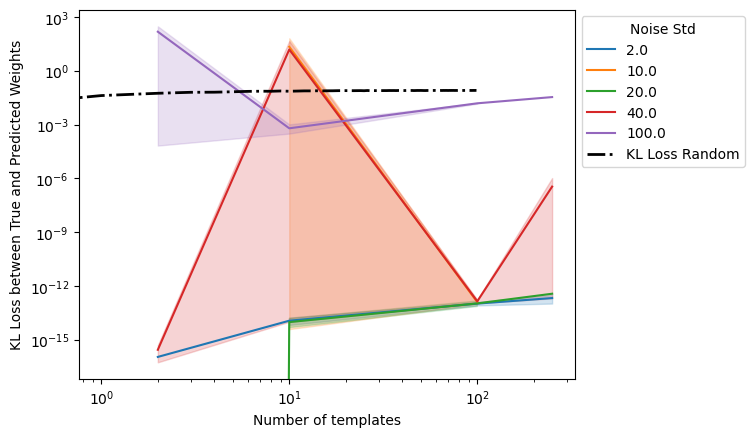

In [6]:
conditions = (final_df['weight_dist'] == 1) 
conditional_df = final_df[conditions]
p = sns.lineplot(data=conditional_df, x='num_templates', y='kl_loss_weights', hue='noise_std', palette='tab10', errorbar='ci', n_boot=5000, seed=10)
plt.plot(kl_loss_mean, label='KL Loss Random', linestyle='-.', linewidth=2, color='black')

p.set_ylabel('KL Loss between True and Predicted Weights')
p.set_xlabel('Number of templates')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)).set_title('Noise Std')
plt.savefig(os.path.join(save_path, 'kl_loss_weights_noise.png'), dpi=300, bbox_inches='tight')

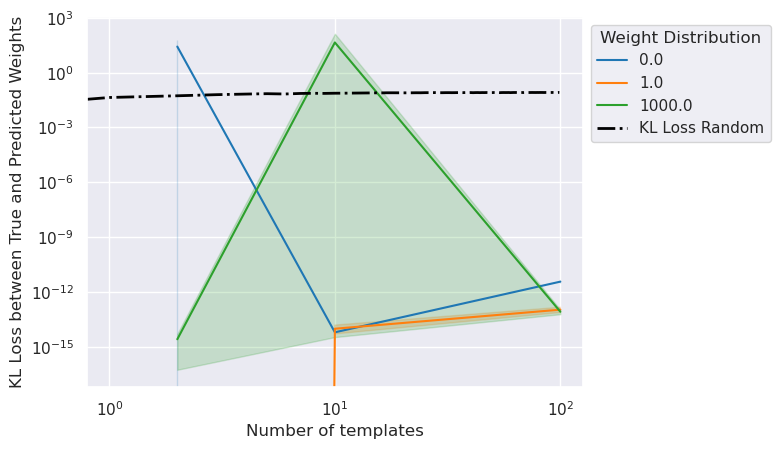

In [195]:
conditions = (final_df['noise_std'] == 20) 
conditional_df = final_df[conditions]
p = sns.lineplot(data=conditional_df, x='num_templates', y='kl_loss_weights', hue='weight_dist', palette='tab10')

plt.plot(kl_loss_mean, label='KL Loss Random', linestyle='-.', linewidth=2, color='black')

p.set_ylabel('KL Loss between True and Predicted Weights')
p.set_xlabel('Number of templates')


plt.xscale('log')
plt.yscale('log')

plt.legend(title='Weight Distribution', loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(save_path, 'kl_loss_weights_weight_dist.png'), dpi=300)

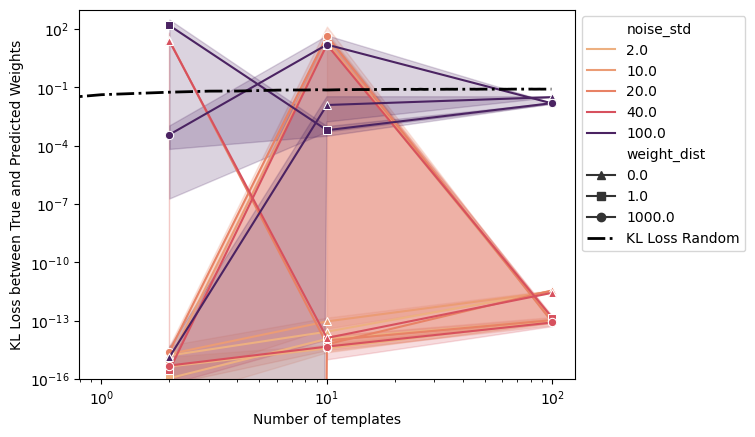

In [11]:
conditions = (final_df['num_templates'] < 250) 
conditional_df = final_df[conditions]
p = sns.lineplot(data=conditional_df, x='num_templates', y='kl_loss_weights', hue='noise_std', style='weight_dist', palette="flare", dashes=False, markers=['^', 's', 'o'])
plt.plot(kl_loss_mean, label='KL Loss Random', linestyle='-.', linewidth=2, color='black')

p.set_ylabel('KL Loss between True and Predicted Weights')
p.set_xlabel('Number of templates')

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-16, 1e3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(save_path, 'kl_loss_weights_combined.png'), dpi=300, bbox_inches='tight')

In [162]:
p.get_legend_handles_labels()

([<matplotlib.lines.Line2D at 0x15540e6381f0>,
 ['0.0', '1.0', '1000.0', 'KL Loss Random'])

In [163]:
conditions = (final_df['noise_std'] == 20) & (final_df['num_templates'] == 10) 
conditional_df = final_df[conditions]
loss_weight_num_temp_10 = conditional_df['kl_loss_weights'].replace([np.inf, -np.inf], np.nan)

In [164]:
np.nanmean(loss_weight_num_temp_10)

14.720102372606988

In [13]:
# Identify infinite values
df_inf = final_df.replace([np.inf, -np.inf], np.nan).isna()

# Combine conditions into a single column
final_df['CombinedCondition'] = list(zip(final_df['num_templates'], final_df['weight_dist'], final_df['noise_std']))

# Get unique combined conditions
combined_conditions = final_df['CombinedCondition'].unique()

# Initialize a dictionary to store counts
inf_counts = {condition: {} for condition in combined_conditions}

# Count infinite values for each combined condition
for condition in combined_conditions:
    condition_df = final_df[final_df['CombinedCondition'] == condition]
    inf_counts[condition] = condition_df.replace([np.inf, -np.inf], np.nan).isna().sum()
    
# Convert the dictionary to a DataFrame for easier plotting
inf_counts_df = pd.DataFrame(inf_counts).transpose().reset_index()

In [14]:
inf_counts_df.drop(inf_counts_df[inf_counts_df.columns[5:].tolist()], axis=1, inplace=True)
new_column_names = ['num_templates', 'weight_dist', 'noise_std', 'weights_num_inf', 'structure_num_inf']
inf_counts_df.columns = new_column_names

In [15]:
inf_counts_df.head()

,num_templates,weight_dist,noise_std,weights_num_inf,structure_num_inf
0,2.0,0.0,40.0,89,0
1,2.0,1000.0,100.0,85,0
2,2.0,0.0,2.0,90,0
3,100.0,1000.0,20.0,0,0
4,10.0,0.0,2.0,93,0


In [16]:
inf_counts_df['weights_freq_inf'] = inf_counts_df['weights_num_inf'] / 100

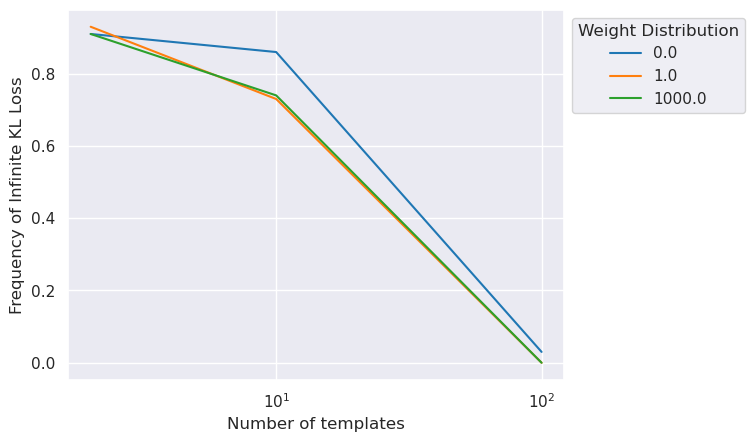

In [196]:
conditions = (inf_counts_df['noise_std'] == 20) 
conditional_df = inf_counts_df[conditions]
p = sns.lineplot(data=conditional_df, x='num_templates', y='weights_freq_inf', hue='weight_dist', palette='tab10')
plt.xscale('log')
p.set_ylabel('Frequency of Infinite KL Loss')
p.set_xlabel('Number of templates')
plt.legend(title='Weight Distribution', loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(save_path, 'kl_loss_weights_weight_dist_inf_freq.png'), dpi=300)

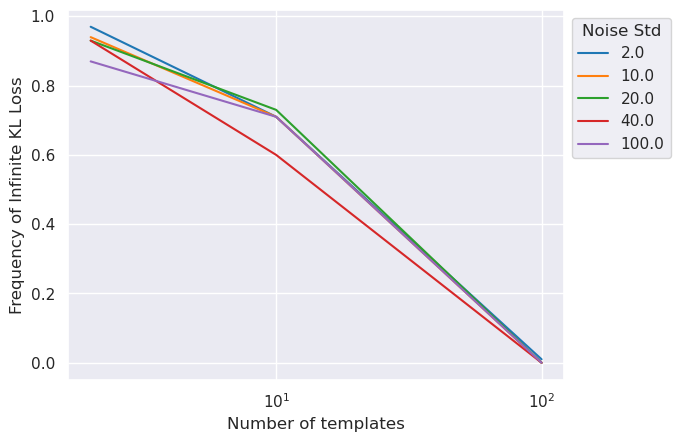

In [197]:
conditions = (inf_counts_df['weight_dist'] == 1) 
conditional_df = inf_counts_df[conditions]
p = sns.lineplot(data=conditional_df, x='num_templates', y='weights_freq_inf', hue='noise_std', palette='tab10')
plt.xscale('log')
p.set_ylabel('Frequency of Infinite KL Loss')
p.set_xlabel('Number of templates')
plt.legend(title='Noise Std', loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(save_path, 'kl_loss_weights_noise_std_inf_freq.png'), dpi=300)

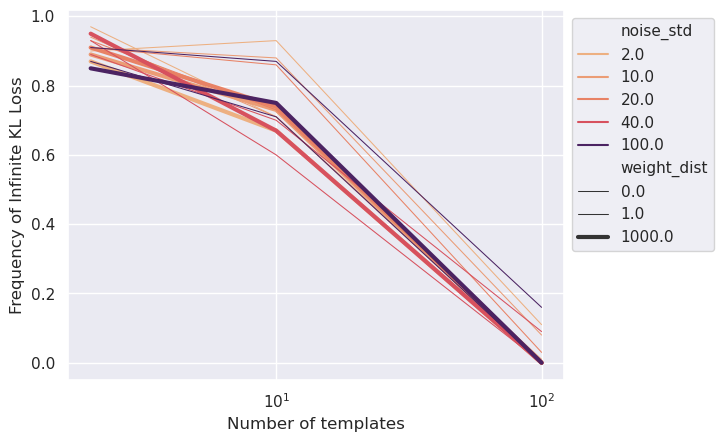

In [27]:
conditions = (inf_counts_df['num_templates'] < 250) 
conditional_df = inf_counts_df[conditions]
p = sns.lineplot(data=conditional_df, x='num_templates', y='weights_freq_inf', hue='noise_std', size='weight_dist', palette="flare")
plt.xscale('log')
p.set_ylabel('Frequency of Infinite KL Loss')
p.set_xlabel('Number of templates')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(save_path, 'kl_loss_weights_inf_freq_combined.png'), dpi=300, bbox_inches='tight')

In [171]:
np.random.dirichlet([0.01 for _ in range(i)], size=None)

array([1.81245013e-111, 1.00000000e+000])

In [172]:
i = 10
random_number_2 = scipy.special.softmax(np.random.rand(i))
random_number_1 = np.zeros(i)
kl_loss = np.sum(scipy.special.kl_div(random_number_1, random_number_2))
kl_loss

1.0

In [173]:
scipy.special.kl_div(random_number_1, random_number_2)

array([0.12530338, 0.06929786, 0.1028164 , 0.06718954, 0.07760831,
       0.08541058, 0.17569831, 0.16103919, 0.06704481, 0.06859162])

In [12]:
i = 2
random_number_1 = scipy.special.softmax(np.random.rand(i))
random_number_2 = np.random.dirichlet([0.1 for _ in range(i)], size=None)
print(random_number_2)
kl_loss = np.sum(scipy.special.kl_div(random_number_1, random_number_2))
kl_loss

[9.99453280e-01 5.46720232e-04]


2.65136552060525

In [175]:
weight_dist = 0
num_templates = 100
num_observations = 1000
alpha = np.maximum(np.ones(num_templates) * weight_dist * 100, np.ones(num_templates))
np.int32(np.random.dirichlet(alpha) * num_observations) + 1

array([13, 13,  2,  5, 23,  5,  3,  2, 11,  7,  1,  1,  6, 13,  1, 33, 12,
        2,  2,  4, 50,  4,  6, 12, 17, 11, 18,  3,  6, 21,  4, 33,  1,  1,
        2,  3,  5,  7,  9,  2,  7,  5,  8,  5, 26, 22, 16, 11, 11, 35,  2,
        2, 16, 12, 39,  5,  1,  6, 25, 14, 32,  9, 13, 14,  1,  1,  1, 14,
       14, 12,  9,  3, 19, 11, 25, 13,  3, 22,  2,  1,  4, 27, 10,  3,  3,
       13,  1,  5, 42,  3,  5,  5, 10,  4, 10,  5,  1, 21,  9,  5],
      dtype=int32)

In [176]:
kl_loss_list = []
num_templates = 2 
num_observations = 1000
weight_dist = 1000
for iter in tqdm(range(1000)):
    random_number_1 = scipy.special.softmax(np.random.rand(num_templates))
    alpha = np.maximum(np.ones(num_templates) * weight_dist * 100, np.ones(num_templates))
    random_number_2 = np.random.dirichlet(alpha)
    kl_loss = np.sum(scipy.special.kl_div(random_number_1, random_number_2))
    kl_loss_list.append(kl_loss)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [177]:
random_number_2

array([0.50089591, 0.49910409])

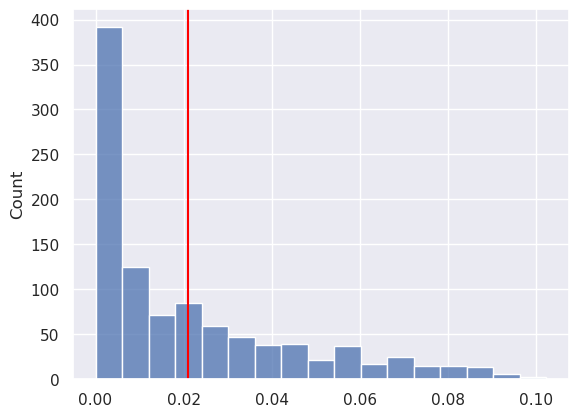

In [178]:
sns.histplot(kl_loss_list)
plt.axvline(np.mean(kl_loss_list), color='red')

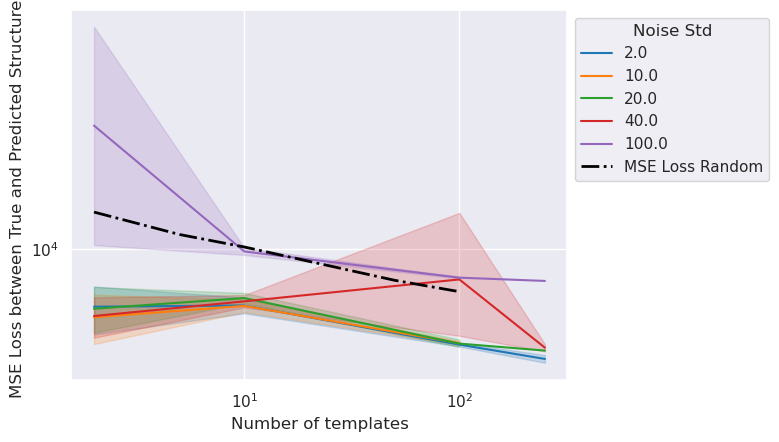

In [24]:
num_temp = [2, 5, 10, 50, 100]
conditions = (final_df['weight_dist'] == 1) 
conditional_df = final_df[conditions]
p = sns.lineplot(data=conditional_df, x='num_templates', y='mse_loss_structures', hue='noise_std', palette='tab10')
plt.plot(num_temp, mse_loss_mean[:len(num_temp)], label='MSE Loss Random', linestyle='-.', linewidth=2, color='black')
plt.xscale('log')
plt.yscale('log')
p.set_ylabel('MSE Loss between True and Predicted Structures')
p.set_xlabel('Number of templates')
plt.legend(title='Noise Std', loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(save_path, 'mse_loss_structure_noise_std.png'), dpi=300, bbox_inches='tight')

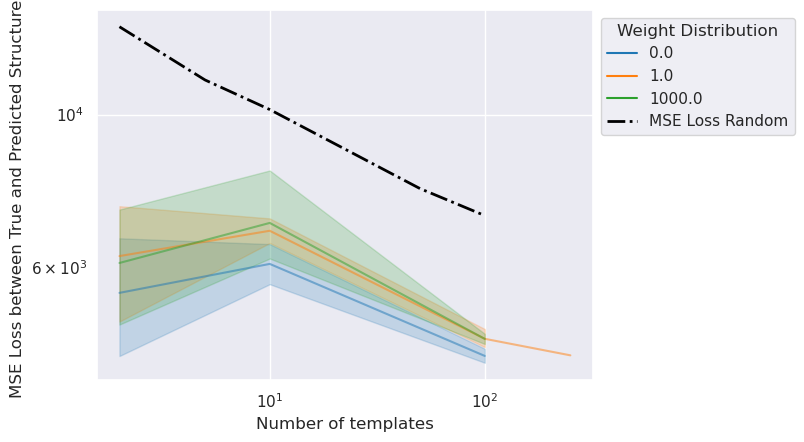

In [25]:
conditions = (final_df['noise_std'] == 20) 
conditional_df = final_df[conditions]
p = sns.lineplot(data=conditional_df, x='num_templates', y='mse_loss_structures', hue='weight_dist', alpha=0.5, palette='tab10')
plt.plot(num_temp, mse_loss_mean[:len(num_temp)], label='MSE Loss Random', linestyle='-.', linewidth=2, color='black')
plt.xscale('log')
plt.yscale('log')
p.set_ylabel('MSE Loss between True and Predicted Structures')
p.set_xlabel('Number of templates')
plt.legend(title='Weight Distribution', loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(save_path, 'mse_loss_structure_weight_dist.png'), dpi=300, bbox_inches='tight')

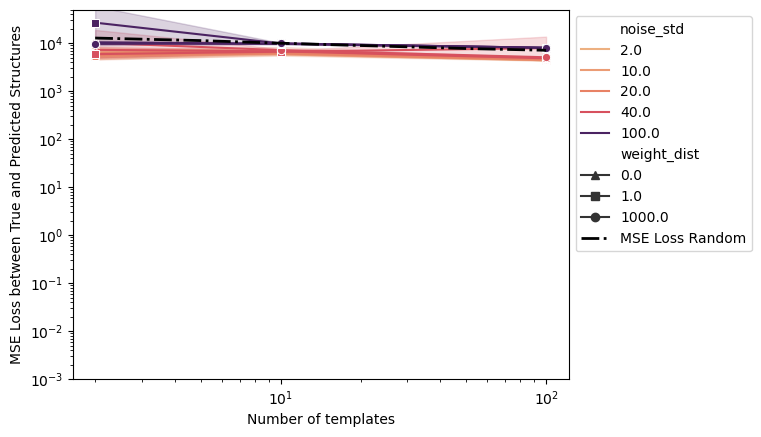

In [10]:
num_temp = [2, 5, 10, 50, 100]
conditions = (final_df['num_templates'] < 250) 
conditional_df = final_df[conditions]
p = sns.lineplot(data=conditional_df, x='num_templates', y='mse_loss_structures', hue='noise_std', style='weight_dist', palette="flare", dashes=False, markers=['^', 's', 'o'])
plt.plot(num_temp, mse_loss_mean[:len(num_temp)], label='MSE Loss Random', linestyle='-.', linewidth=2, color='black')
plt.xscale('log')
plt.yscale('log')
p.set_ylabel('MSE Loss between True and Predicted Structures')
p.set_xlabel('Number of templates')
plt.ylim([1e-3, 5e4])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(save_path, 'mse_loss_structure_combined.png'), dpi=300, bbox_inches='tight')